In [21]:
#Libraries for tables manipulation
import pandas as pd
import numpy as np
import datetime

#Libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

#To not receive warning messages
import warnings
warnings.filterwarnings('ignore')

#Libraries for linear regression modelling and evaluation
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score

#Preprocessing libraries
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import minmax_scale, StandardScaler, OneHotEncoder, PowerTransformer



In [2]:
data = pd.read_csv("../data/mvp_export.csv",index_col = 0)

In [3]:
data

,id,comm_rec_week,no_recipes_submitted,avg_comments_recipes,avg_ratings_recipes,avg_sentiment_recipes,minutes,n_steps,n_ingredients,weekday_posted,month_posted
0,137739,0.004326,735,3.068027,4.596259,0.327186,55,11,7,4,9
1,31490,0.004635,366,5.669399,4.324293,0.320801,30,9,6,0,6
2,112140,0.001384,7,1.428571,4.714286,0.410158,130,6,13,4,2
3,59389,0.002439,115,3.721739,4.369417,0.327694,45,11,11,0,4
4,44061,0.001184,91,9.725275,4.375281,0.310879,190,5,8,4,10
...,...,...,...,...,...,...,...,...,...,...,...
231632,486161,0.018143,172,4.093023,4.677495,0.346470,60,7,22,2,8
231633,493372,0.003208,1,1.000000,5.000000,-0.086061,5,1,13,2,1
231634,308080,0.009070,2553,4.958480,4.440109,0.339765,40,7,8,5,6
231635,298512,0.001789,40,2.450000,4.176564,0.332633,29,9,10,1,4


checking the distribution of the numerical variables we can see that some scale transformation and we we'll have to deal with some ouliers, as there are very extreme ones, as well as the distributions being very skewed to the right, or to the left in the case of the average ratings. 

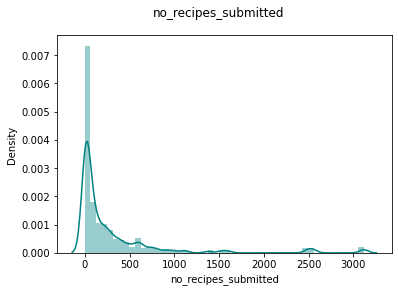

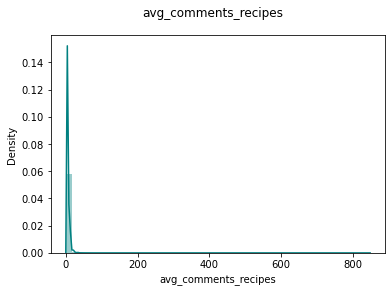

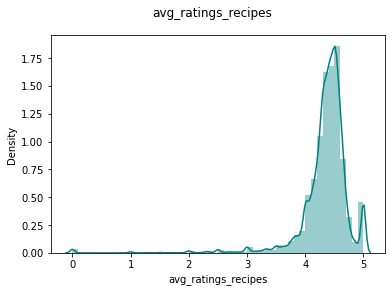

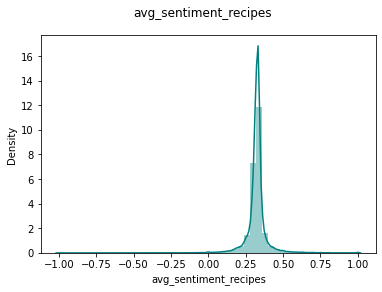

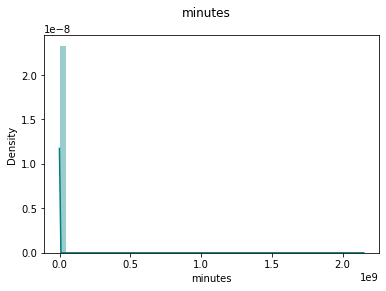

In [4]:
for col in ['no_recipes_submitted','avg_comments_recipes','avg_ratings_recipes','avg_sentiment_recipes', 'minutes']:
    sns.distplot(data[col], color = 'teal')
    plt.suptitle(col)
    plt.show()

By the look of the distribution of the variables, we will need to clean some outliers and apply some transformation as steps for preprocessing.
We start by checking the numerical variables:

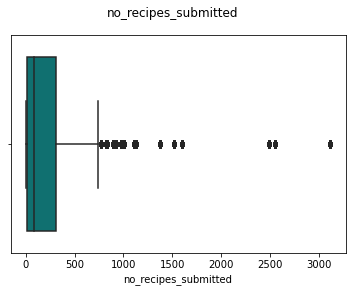

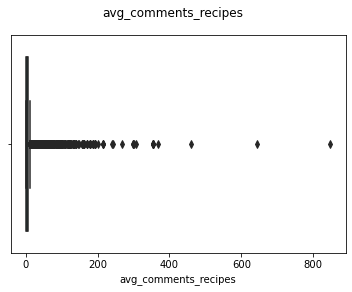

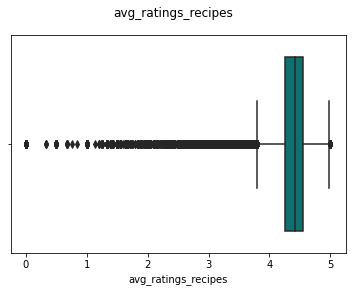

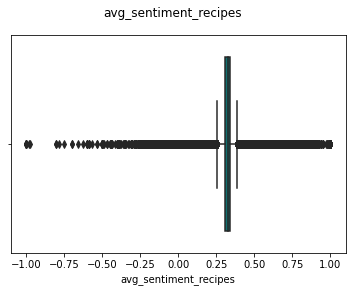

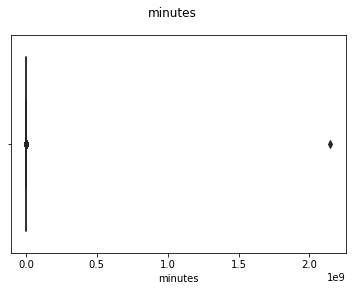

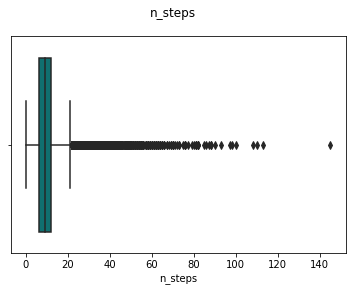

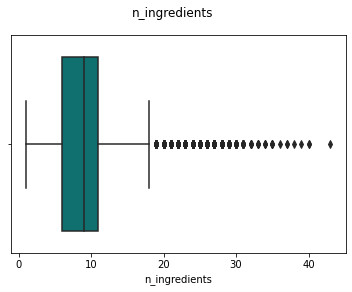

In [5]:
for col in ['no_recipes_submitted','avg_comments_recipes','avg_ratings_recipes','avg_sentiment_recipes', 'minutes','n_steps','n_ingredients']:
    sns.boxplot(data[col], color = 'teal')
    plt.suptitle(col)
    plt.show()

We have to be very careful with outliers that correspond to columns other than minutes, n_ingredients and n_steps, as those columns correspond to characteristics of the user that uploaded the recipe, and if we remove users that submitted a lot of recipes, we will remove too many of our database data points. If a good result is not achieved, it might be good to bin these columns and treat them as categoricals

In [6]:
data = data[data['no_recipes_submitted']<2000]
data.shape

(223473, 11)

In [7]:
data = data[data['avg_comments_recipes']<200]
data.shape

(223453, 11)

In [8]:
data = data[data['avg_sentiment_recipes']>-0.75]
data.shape

(223441, 11)

We'll take out all recipes that take over 12 hours to cook

In [9]:
data = data[data['minutes']<720]
data.shape

(220683, 11)

In [10]:
data = data[data['n_steps']<40]
data.shape

(220115, 11)

In [11]:
data = data[data['n_ingredients']<20]
data.shape

(217905, 11)

In [12]:
data = data[data['no_recipes_submitted']<1000]
data.shape

(210349, 11)

Text(0, 0.5, 'avg_comments_recipes')

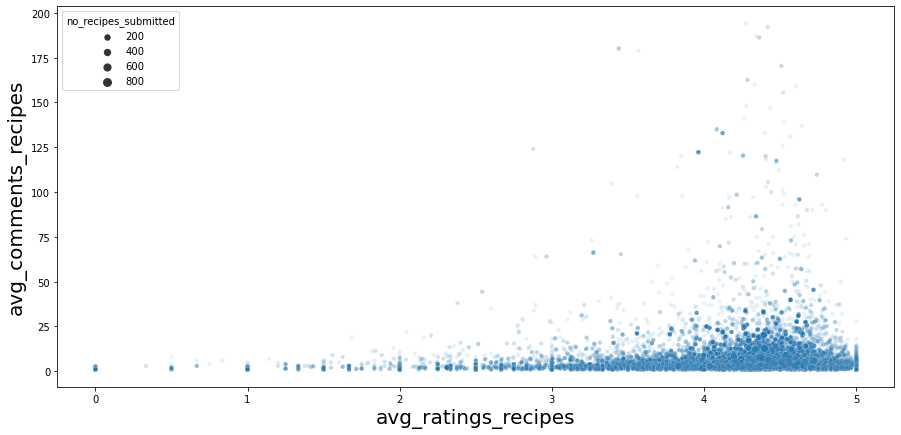

In [13]:
plt.figure(figsize=(15,7))
xplt = 'avg_ratings_recipes'
yplt = 'avg_comments_recipes'
plot = sns.scatterplot(data = data, y = yplt, x = xplt, size=data['no_recipes_submitted'],alpha =.1,palette="mako")
plot.set_xlabel(xplt,fontsize=20)
plot.set_ylabel(yplt,fontsize=20)

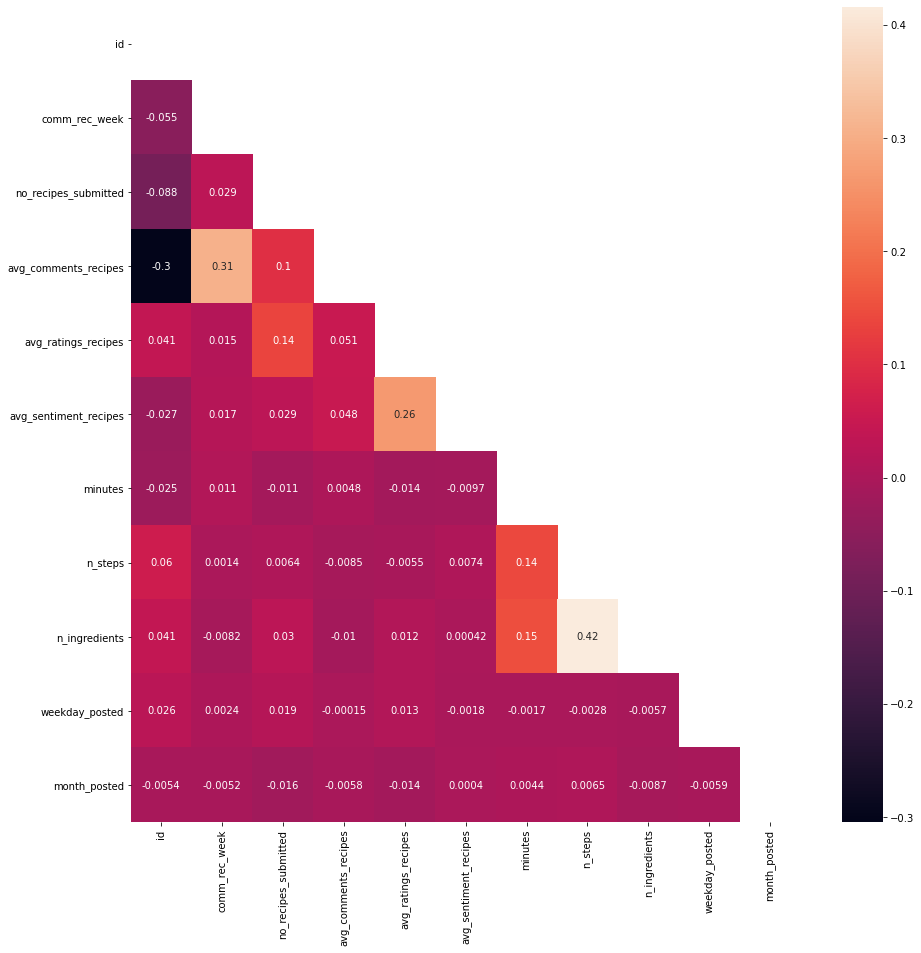

In [14]:
 def corr_matr_show(data):
    correlations_matrix = data.corr()
    mask = np.zeros_like(correlations_matrix)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(15, 15))
    ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
    plt.show()
    
corr_matr_show(data)

We transform categoricals into dtype_objects 

In [15]:
data['weekday_posted'] = data['weekday_posted'].astype(object)
data['month_posted'] = data['month_posted'].astype(object)

Split X and y


In [33]:
X = data.drop(['id','comm_rec_week','month_posted'], axis=1)
y = data['comm_rec_week']

Separate X categorical and X numerical

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

Creating preprocessing pipeline for categoricals 

In [35]:
cat_transf = Pipeline(steps=[
                            ('onehot',OneHotEncoder(handle_unknown='ignore'))
                             ])

In [36]:
num_transf = Pipeline(steps=[
                             ('scaler', StandardScaler()),
                             ('transformer', PowerTransformer()) 
                              ])

In [37]:
preprocessor = ColumnTransformer(transformers=[
                                                ('cat', cat_transf, selector(dtype_include="object")),
                                                ('num', num_transf, selector(dtype_exclude="object"))
                                                 ])

Prototyping the pipeline_ 


In [38]:
pipe_lr = Pipeline([
        ('preprocessing', preprocessor),
        ('transformer', PowerTransformer()),
        ('regressor',linear_model.LinearRegression())
        ])

In [39]:
pipe_lr.fit(X_train, y_train)
print("model score: %.3f" % pipe_lr.score(X_test, y_test))

model score: 0.042


In [40]:
y_test_predict = pipe_lr.predict(X_test)

In [41]:
print("MSE:      {:.9f}".format(mean_squared_error(y_test, y_test_predict)))
print("R2 score: {:.3f}".format(r2_score(y_test, y_test_predict)))

MSE:      0.000479163
R2 score: 0.042


In [42]:
pipe_SGDreg = Pipeline([
        ('preprocessing', preprocessor),
        ('transformer', PowerTransformer()),
        ('SGDregressor',linear_model.SGDRegressor())
        ])

In [43]:
pipe_lr.fit(X_train, y_train)
print("model score: %.3f" % pipe_lr.score(X_test, y_test))

model score: 0.042


In [44]:
y_test_predict = pipe_lr.predict(X_test)

In [45]:
print("MSE:      {:.9f}".format(mean_squared_error(y_test, y_test_predict)))
print("R2 score: {:.3f}".format(r2_score(y_test, y_test_predict)))

MSE:      0.000479163
R2 score: 0.042


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210349 entries, 0 to 231636
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     210349 non-null  int64  
 1   comm_rec_week          210349 non-null  float64
 2   no_recipes_submitted   210349 non-null  int64  
 3   avg_comments_recipes   210349 non-null  float64
 4   avg_ratings_recipes    210349 non-null  float64
 5   avg_sentiment_recipes  210349 non-null  float64
 6   minutes                210349 non-null  int64  
 7   n_steps                210349 non-null  int64  
 8   n_ingredients          210349 non-null  int64  
 9   weekday_posted         210349 non-null  object 
 10  month_posted           210349 non-null  object 
dtypes: float64(4), int64(5), object(2)
memory usage: 19.3+ MB


In [47]:
results = pd.DataFrame({'test':y_test,'prediction':y_test_predict})
results

,test,prediction
134816,0.003927,0.007743
146930,0.001548,0.015499
155088,0.006872,0.005034
131301,0.003366,0.001411
172880,0.002185,0.006717
...,...,...
221613,0.024038,0.011243
146006,0.002112,-0.000925
170453,0.011990,0.012537
164002,0.006567,0.009530


<AxesSubplot:xlabel='test', ylabel='prediction'>

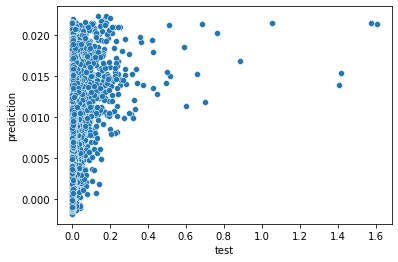

In [48]:
sns.scatterplot(data=results, x='test', y='prediction')